# Financial news category tagger data extraction

## Getting dataset and metadata

In [1]:
import requests

try:
    data_response = requests.get("https://datasets-server.huggingface.co/rows?dataset=zeroshot%2Ftwitter-financial-news-topic&config=default&split=train&offset=0&length=100")
    if data_response.status_code == 200:
        print(data_response)
except Exception as e:
    print(f"Non-success : {e}")

<Response [200]>


In [2]:
# Listing the split names for this dataset:

try:
    splits_response = requests.get("https://datasets-server.huggingface.co/splits?dataset=zeroshot%2Ftwitter-financial-news-topic")
    if response.status_code == 200:
        splits_data = splits_response.content
        print('splits json obtained')
        print()
        print(splits_data)
except Exception as e:
    print(f"Non-success : {e}")

Non-success : name 'response' is not defined


In [3]:
from datasets import load_dataset

# Specify the dataset you want to download
dataset_name = "zeroshot/twitter-financial-news-topic"  # Use underscores instead of hyphens

# Load the dataset
dataset = load_dataset(dataset_name)

# Print the first few examples
print(dataset['train'][:5])

Found cached dataset csv (/Users/carlosvarela/.cache/huggingface/datasets/zeroshot___csv/zeroshot--twitter-financial-news-topic-469567573910d47b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/2 [00:00<?, ?it/s]

{'text': ["Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; more  https://t.co/QPN8Gwl7Uh", 'Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says  https://t.co/fLS2w57iCz', 'Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition  https://t.co/1EmtywmYpr', "Analysts react to Tesla's latest earnings, break down what's next for electric car maker  https://t.co/kwhoE6W06u", 'Netflix and its peers are set for a ‘return to growth,’ analysts say, giving one stock 120% upside  https://t.co/jPpdl0D9s4'], 'label': [0, 0, 0, 0, 0]}


In [4]:
# Explore what the dataset contains:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16990
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4117
    })
})

In [28]:
# Separating split
training_split = dataset['train']
testing_split = dataset['validation']

## Training set exploratorey data analysis

In [29]:
import pandas as pd

training_df = pd.DataFrame(training_split)
print('data labels: ')
training_df['label'].unique()

data labels: 


array([ 0,  2,  9,  8,  4,  5,  6,  1,  7, 10, 11, 12, 13, 14, 15, 17, 16,
       18, 19,  3])

### Understanding the labels

**Dataset Description**

The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their topic.

**topics**
- "LABEL_0": "Analyst Update"
- "LABEL_1": "Fed | Central Banks"
- "LABEL_2": "Company | Product News"
- "LABEL_3": "Treasuries | Corporate Debt"
- "LABEL_4": "Dividend"
- "LABEL_5": "Earnings"
- "LABEL_6": "Energy | Oil"
- "LABEL_7": "Financials"
- "LABEL_8": "Currencies"
- "LABEL_9": "General News | Opinion"
- "LABEL_10": "Gold | Metals | Materials"
- "LABEL_11": "IPO"
- "LABEL_12": "Legal | Regulation"
- "LABEL_13": "M&A | Investments"
- "LABEL_14": "Macro"
- "LABEL_15": "Markets"
- "LABEL_16": "Politics"
- "LABEL_17": "Personnel Change"
- "LABEL_18": "Stock Commentary"
- "LABEL_19": "Stock Movement"

As stated in the Huggingface card of the author:
- The data was collected using the Twitter API. The current dataset supports the multi-class classification task.

### Exploring data split balancing

In [30]:
import matplotlib.pyplot as plt

# Create dataframe with count of records by label:
label_counts = pd.DataFrame(training_df['label'].value_counts()).reset_index()
label_counts

,label,count
0,2,3545
1,18,2118
2,14,1822
3,9,1557
4,5,987
5,16,985
6,1,837
7,19,823
8,7,624
9,6,524


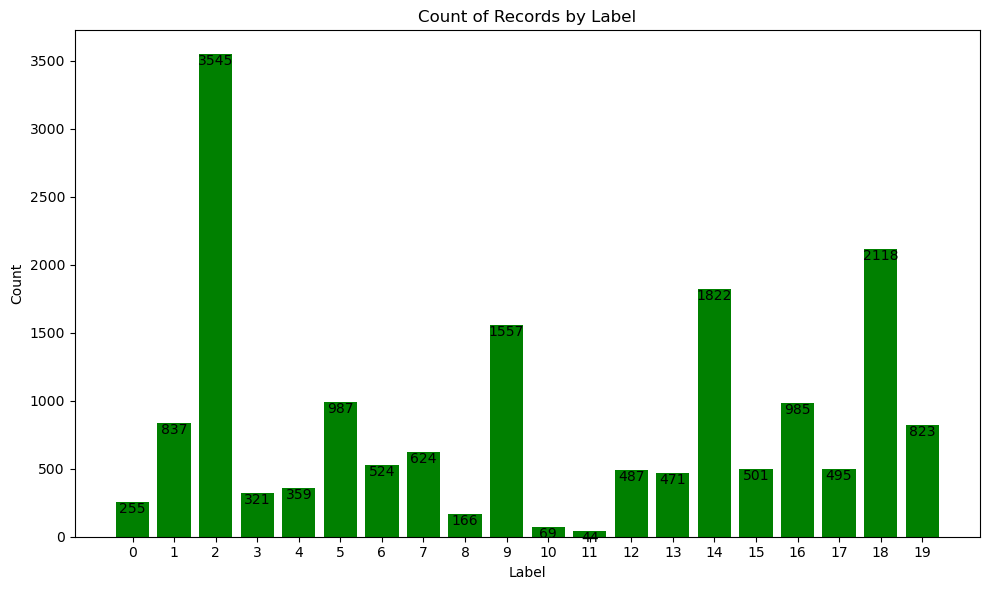

In [17]:
# Plot for visual inspection:
plt.figure(figsize = (10,6))
bars = plt.bar(label_counts['label'], label_counts['count'], color = 'green')

# Add title and labels:
plt.title('Count of Records by Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Add count values to each bar:
for bar, count in zip(bars, label_counts['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='top')

# Rotate labels for better viz:
plt.xticks(label_counts['label'])
# Adjust layout to prevent cropping labels:
plt.tight_layout()
plt.show()

As we can see, the dataset lacks balancing...

In [9]:
#Perform initial EDA prior to cleaning for training split:
from ydata_profiling import ProfileReport

pre_cleaning_profile = ProfileReport(training_df, title="Financial News Pre-cleaning Profiling Report")
pre_cleaning_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA Assessment:

As per the initial report, it does not look like the dataset contain any missing values or duplicates. Therefore, we will proceed to prepare the data for NLP.
- Tokenization
- Lemmatization
- Stop words removal

In [32]:
# Remove special characters and bring to lowercase:
# Remove special characters, bring to lowercase, and remove 's
training_df['cleaned_text'] = (training_df['text']
                                   .str.lower()
                                   .replace(r'\b\'s\b', '', regex=True)
                                   .str.replace(':', ''))

training_df.head(5)

,text,label,cleaned_text
0,Here are Thursday's biggest analyst calls: App...,0,"here are thursday biggest analyst calls apple,..."
1,Buy Las Vegas Sands as travel to Singapore bui...,0,buy las vegas sands as travel to singapore bui...
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,"piper sandler downgrades docusign to sell, cit..."
3,"Analysts react to Tesla's latest earnings, bre...",0,"analysts react to tesla latest earnings, break..."
4,Netflix and its peers are set for a ‘return to...,0,netflix and its peers are set for a ‘return to...


In [33]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Loading the language model:
nlp = spacy.load("en_core_web_sm")

# Applying model to a dataframe column:
training_df['docs'] = training_df['cleaned_text'].apply(nlp)

# Defining a function to remove stop words and punctuations using spacy's assets:
def nlp_tokenizer(doc):
    docs_no_stops = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and not token.is_punct]
    return docs_no_stops

training_df['docs'] = training_df['docs'].apply(nlp_tokenizer)

In [34]:
training_df.head(3)

,text,label,cleaned_text,docs
0,Here are Thursday's biggest analyst calls: App...,0,"here are thursday biggest analyst calls apple,...","[thursday, big, analyst, apple, amazon, tesla,..."
1,Buy Las Vegas Sands as travel to Singapore bui...,0,buy las vegas sands as travel to singapore bui...,"[buy, las, vegas, sand, travel, singapore, bui..."
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,"piper sandler downgrades docusign to sell, cit...","[piper, sandler, downgrade, docusign, sell, ci..."


Let us now keep the columns needed for training the category tagger, and run the profile report again to assess the quality of the data.

In [41]:
model_training_set = training_df[['docs', 'label']]
model_training_set.head(10)

,docs,label
0,"[thursday, big, analyst, apple, amazon, tesla,...",0
1,"[buy, las, vegas, sand, travel, singapore, bui...",0
2,"[piper, sandler, downgrade, docusign, sell, ci...",0
3,"[analyst, react, tesla, late, earning, break, ...",0
4,"[netflix, peer, set, return, growth, analyst, ...",0
5,"[barclay, believe, earning, underperforming, s...",0
6,"[bernstein, upgrade, alibaba, share, rally, 20...",0
7,"[analyst, react, netflix, strong, quarter, poi...",0
8,"[buy, chevron, share, look, attractive, level,...",0
9,"[morgan, stanley, global, stock, set, earning,...",0


To follow up on the data transformation, let's transform docs into text sentences.

In [42]:
# Remove colons:
model_training_set['entities'] = model_training_set['docs'].apply(lambda tokens: ' '.join(tokens))

# Generate EDA report post-cleaning:
final_training_Set = model_training_set[['entities', 'label']]

/var/folders/p7/0l629d4j6wxccht_62k8btmr0000gn/T/ipykernel_70216/2689430001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_training_set['entities'] = model_training_set['docs'].apply(lambda tokens: ' '.join(tokens))


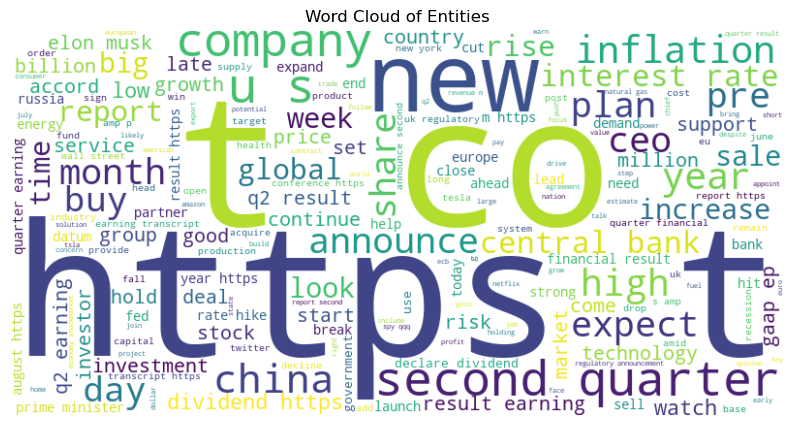

In [47]:
from wordcloud import WordCloud

# Generate the word cloud
text = ' '.join(final_training_Set['entities'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.title('Word Cloud of Entities')
plt.show()

Let's remove words such as https, co, and t, that are not meaningful for the model.

In [48]:
# Remove specific words from each record in the 'entities' column:
words_to_remove = ['https', 'co', 't']
for word in words_to_remove:
    final_training_Set['entities'] = final_training_Set['entities'].str.replace(r'\b{}\b'.format(word), '', regex=True)

final_training_Set.head(5)

/var/folders/p7/0l629d4j6wxccht_62k8btmr0000gn/T/ipykernel_70216/555246609.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_training_Set['entities'] = final_training_Set['entities'].str.replace(r'\b{}\b'.format(word), '', regex=True)


,entities,label
0,thursday big analyst apple amazon tesla palant...,0
1,buy las vegas sand travel singapore builds wel...,0
2,piper sandler downgrade docusign sell cite ele...,0
3,analyst react tesla late earning break electri...,0
4,netflix peer set return growth analyst stock 1...,0


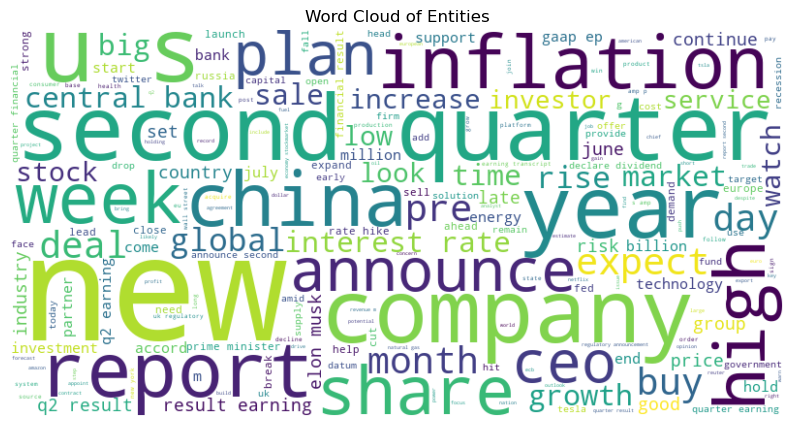

In [49]:
# Generate the word cloud again
text = ' '.join(final_training_Set['entities'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.title('Word Cloud of Entities')
plt.show()

Uppon inspecting the records manually, we have realized there are hyperlinks messing the sentence structure. Example: //. m3apoprgu0. There are also emojis that we need to remove so that they don't interfere with the model's training.

In [51]:
# Remove everything after '//'
final_training_Set['entities'] = final_training_Set['entities'].str.replace(r'\/\/.*$', '', regex=True)

final_training_Set

/var/folders/p7/0l629d4j6wxccht_62k8btmr0000gn/T/ipykernel_70216/1646912496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_training_Set['entities'] = final_training_Set['entities'].str.replace(r'\/\/.*$', '', regex=True)


,entities,label
0,thursday big analyst apple amazon tesla palant...,0
1,buy las vegas sand travel singapore builds wel...,0
2,piper sandler downgrade docusign sell cite ele...,0
3,analyst react tesla late earning break electri...,0
4,netflix peer set return growth analyst stock 1...,0
...,...,...
16985,kfw credit line uniper raise 8 bln eur handels...,3
16986,kfw credit line uniper raise 8 bln eur handels...,3
16987,russian,3
16988,global esg bond issuance post h1 dip supranati...,3


Let's now remove empty rows and meaningless tokens.

In [54]:
# Remove emojis:
final_training_Set['entities'] = final_training_Set['entities'].str.replace(r'[^\x00-\x7F]+', '', regex=True)

# Remove empty rows:
final_training_Set.dropna()

# Remove rows where there is only one word using a mask:
final_training_Set['word_count'] = final_training_Set['entities'].str.split().str.len()
final_training_Set = final_training_Set[final_training_Set['word_count'] > 2]

# Drop the 'word_count' column as it's no longer needed
final_training_Set = final_training_Set.drop(columns=['word_count'])
final_training_Set

/var/folders/p7/0l629d4j6wxccht_62k8btmr0000gn/T/ipykernel_70216/4259705214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_training_Set['entities'] = final_training_Set['entities'].str.replace(r'[^\x00-\x7F]+', '', regex=True)


,entities,label
0,thursday big analyst apple amazon tesla palant...,0
1,buy las vegas sand travel singapore builds wel...,0
2,piper sandler downgrade docusign sell cite ele...,0
3,analyst react tesla late earning break electri...,0
4,netflix peer set return growth analyst stock 1...,0
...,...,...
16984,china developer face $ 13bn wall dollar bond p...,3
16985,kfw credit line uniper raise 8 bln eur handels...,3
16986,kfw credit line uniper raise 8 bln eur handels...,3
16988,global esg bond issuance post h1 dip supranati...,3


now we are ready to save our training set for vectorization!

In [55]:
final_training_Set.to_csv('financial_news_topic_processed.csv', index = False)